In [1]:
# Import packages as needed. Maybe PIL?
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.patches import YAArrow

import numpy as np

import textwrap

from astropy.io import ascii, fits
from astropy.io.fits import getdata

In [99]:
def spectraChart():
    
    # set up figure 
    f, axs = plt.subplots(5, sharex = True, figsize=(20,20))
    f.set_facecolor('white')
    f.canvas.set_window_title("Spectra")

  
    plt.style.use('fivethirtyeight')
    
    axs[-1].set_xlim(0.3,1)
    axs[-1].set_xlabel('Wavelength ($\mu m$)')
    axs[0].set_title("Spectra")
    
    # SDSS filters
    # Doi, M., Tanaka, M., Fukugita, M., Gunn, J. E., Yasuda, N., Ivezić, Ž., ... & Leger, R. F. (2010). Photometric response functions of the sloan digital sky survey imager. The Astronomical Journal, 139(4), 1628.
    sdssGrizy = ascii.read('grizyFilters.txt',format='tab')
    sdssPlt = 4
    
    axs[sdssPlt].set_ylabel("SDSS Filter Response")
    lambdaMicron = sdssGrizy['lambda']*(10**-4)
    axs[sdssPlt].plot(lambdaMicron,sdssGrizy['u'],'#008fd5',label='u')
    axs[sdssPlt].plot(lambdaMicron,sdssGrizy['g'],'#6d904f',label='g')
    axs[sdssPlt].plot(lambdaMicron,sdssGrizy['r'],'#fc4f30',label='r')
    axs[sdssPlt].plot(lambdaMicron,sdssGrizy['i'],'#810f7c',label='i')
    axs[sdssPlt].plot(lambdaMicron,sdssGrizy['z'],'#8b8b8b',label='z')
    axs[sdssPlt].legend()
    
    # Solar spectrum
    # http://www.eso.org/observing/dfo/quality/UVES/pipeline/solar_spectrum.html
    fitsData = fits.open("solar_spectrum.fits")
    solarSpec = fitsData[0].data
    fitsData.close()
    solPlt = 2
    
    axs[solPlt].set_ylabel("UVES solar spectrum (flux)")
    #axs[solPlt].set_ylim([0,1.5])
    
    xvals = np.zeros(len(solarSpec[1000:]))
    xvals[0] = 3000
    for i in range(1,len(xvals)):
        xvals[i] = xvals[i-1] + 0.0124862
    axs[solPlt].plot(xvals*(10**-4),solarSpec[1000:],'#e5ae38')
    
    # Sky Spectrum
    # http://www.eso.org/observing/dfo/quality/UVES/pipeline/sky_spectrum.html 
    skyPlt = 3  
    axs[skyPlt].set_ylabel("Sky Emission (Flux)")
    
    specFiles = ["fluxed_sky_346.fits",
                 "fluxed_sky_437.fits",
                 "fluxed_sky_580L.fits",
                 "fluxed_sky_580U.fits",
                 "fluxed_sky_860L.fits",
                 "fluxed_sky_860U.fits"]
    specRanges = [(3140,3760),
                  (3740,4860),
                  (4810,5770),
                  (5830,6790),
                  (6700,8560),
                  (8600,10430)]
       
    for fle,rnge in zip(specFiles,specRanges):
        skySpec = getdata(fle, 0)
        xvals = np.linspace(rnge[0],rnge[1],len(skySpec))
        axs[skyPlt].plot(xvals*(10**-4),skySpec,'#810f7c') 
        
    # Galaxy Spectrum
    # Y-Axis in magnitude units. Spectral range in Optical.
    ell_spec = ascii.read('elliptical_template.ascii')
    bulge_spec = ascii.read('bulge_template.ascii')
    sa_spec = ascii.read('sa_template.ascii')
    galPlt = 0
    
    axs[galPlt].set_ylabel("Vis. Mag (Flux)")
    lambdaGalE = ell_spec['col1']*(10**-4)
    lambdaGalB = bulge_spec['col1']*(10**-4)
    lambdaGalS = sa_spec['col1']*(10**-4)
    axs[galPlt].plot(lambdaGalE,ell_spec['col2'],'#008fd5',label='Elliptical')
    axs[galPlt].plot(lambdaGalB,bulge_spec['col2'],'#6d904f',label='Bulge')
    axs[galPlt].plot(lambdaGalS,sa_spec['col2'],'#fc4f30',label='Spiral')
    axs[galPlt].legend(loc='best')
    
    # Interstellar Dust
    # Y-Axis in magnitude units. Spectral range in Optical.
    #dust_spec = ascii.read('IS_dust.txt', data_start = 3, format='tab')
    #dustPlt = 1
    
    #axs[dustPlt].set_ylabel("C_ext/H")
    #lambdaDust = dust_spec['lambda']*(10**-4)
    #axs[dustPlt].plot(labdaDust, dust_spec['C_ext/H'],'#008fd5',label='ISM Dust')
    #axs[dustPlt].legend(loc='best')
    
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    
    plt.tight_layout()    
    plt.savefig('spectra.pdf')
    plt.show()

KeyError: 'lambda'

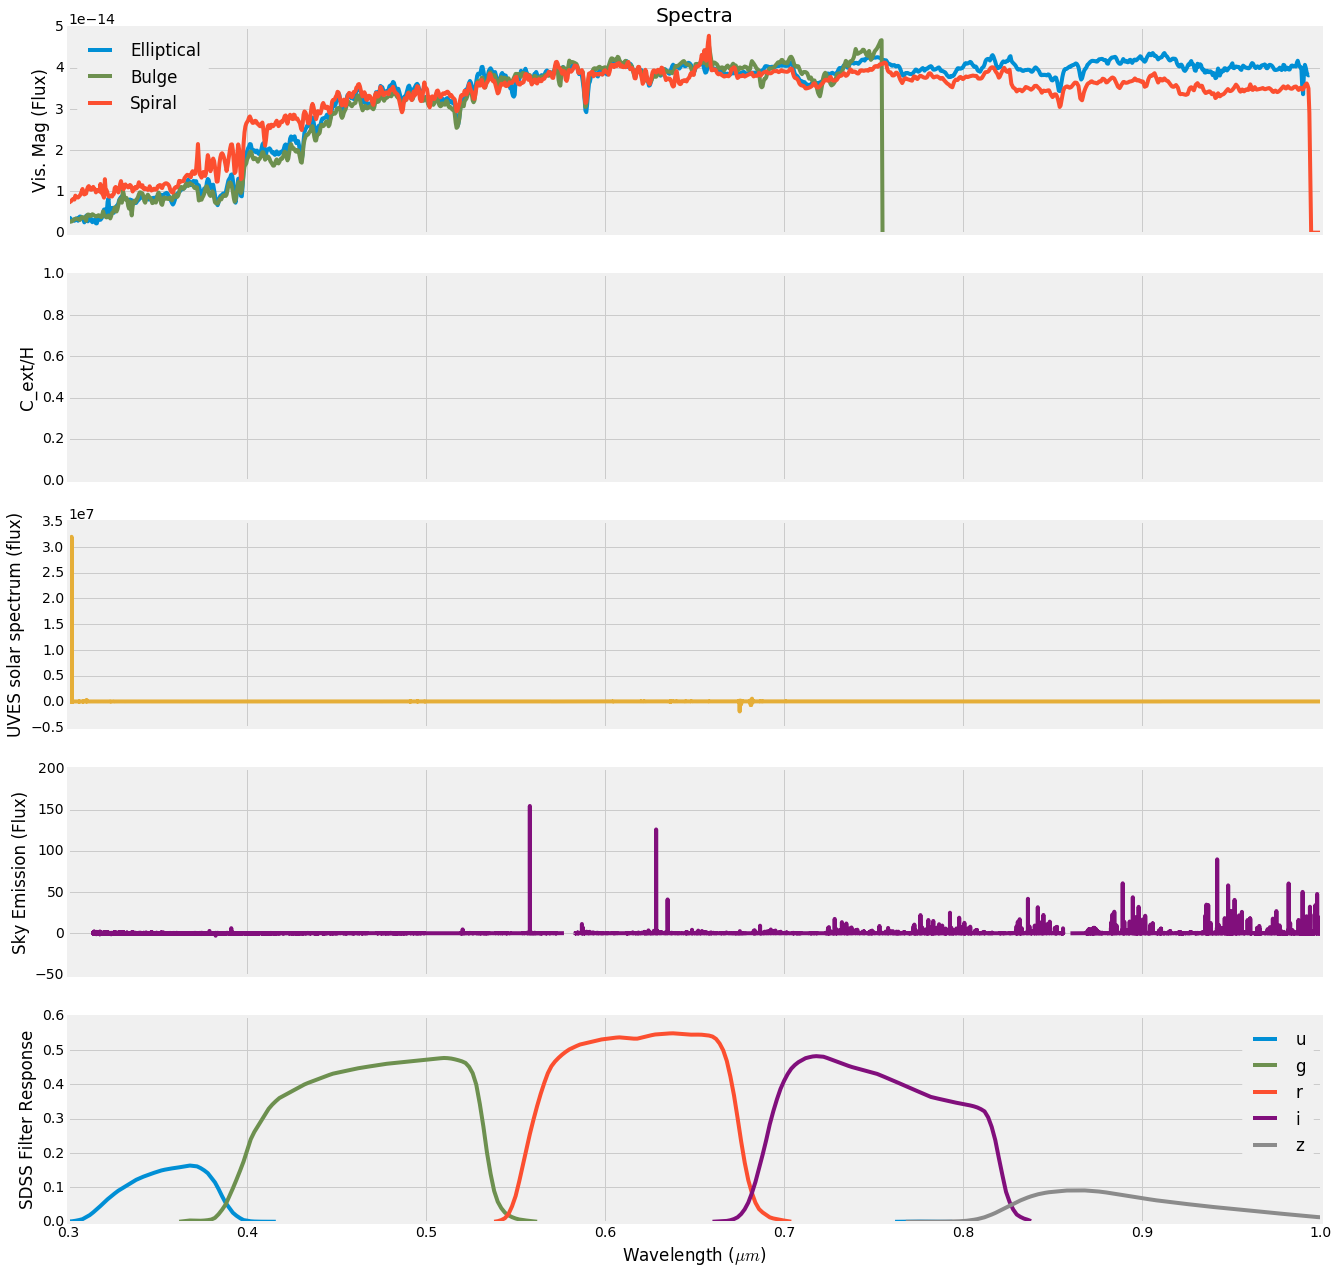

In [100]:
spectraChart()